2024-06-09 20:45:29.422303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 20:45:29.730860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-09 20:45:29.730897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-09 20:45:29.808195: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 20:45:30.798411: W tensorflow/stream_executor/platform/de

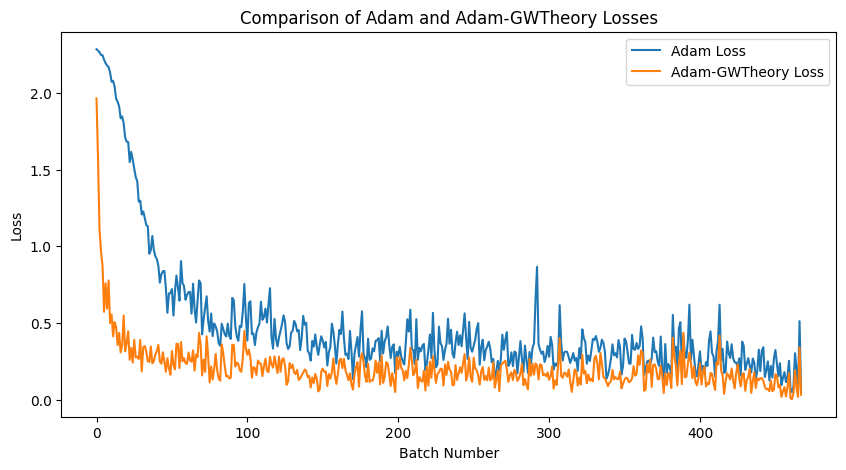

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# Load MNIST dataset
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
train_labels = to_categorical(train_labels)

# Define a simple neural network
def initialize_params(input_dim, hidden_dim, output_dim):
    np.random.seed(42)
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def compute_loss(Y, Y_hat):
    m = Y.shape[0]
    return -np.sum(Y * np.log(Y_hat + 1e-8)) / m

def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(X, Y, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]
    dZ2 = A2 - Y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon):
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)
    W1 -= learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
    b1 -= learning_rate * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
    W2 -= learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
    b2 -= learning_rate * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2


last_persistence = 1  # Initialize last_persistence
base_learning_rate = 0.01  # Initialize base_learning_rate

def compute_persistence(params, decay_rate=0.5):
    # Compute the persistence using an adjustable exponential decay rate of the norm
    norm = np.linalg.norm(np.concatenate([p.flatten() for p in params]))
    return np.exp(-decay_rate * norm)  

def update_params_with_adam_gwtheory(W1, b1, W2, b2, dW1, db1, dW2, db2, t, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, beta1, beta2, epsilon):
    global last_persistence, base_learning_rate

    # Calculate persistence and adjust learning rate dynamically
    persistence = compute_persistence([W1, b1, W2, b2])
    learning_rate = base_learning_rate * (2 if persistence < last_persistence else 0.5)
    last_persistence = persistence

    # Update momentum and velocity
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)

    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)

    W1 -= learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
    b1 -= learning_rate * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
    W2 -= learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
    b2 -= learning_rate * mb2_corr / (np.sqrt(vb2_corr) + epsilon)

    return W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2


# Initialize parameters for both Adam and Adam-GWTheory
W1, b1, W2, b2 = initialize_params(784, 128, 10)
mW1, mb1, mW2, mb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)
vW1, vb1, vW2, vb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)

# Copy parameters for Adam-GWTheory
W1_gw, b1_gw, W2_gw, b2_gw = np.copy(W1), np.copy(b1), np.copy(W2), np.copy(b2)
mW1_gw, mb1_gw, mW2_gw, mb2_gw = np.copy(mW1), np.copy(mb1), np.copy(mW2), np.copy(mb2)
vW1_gw, vb1_gw, vW2_gw, vb2_gw = np.copy(vW1), np.copy(vb1), np.copy(vW2), np.copy(vb2)

# Training loop for Adam and Adam-GWTheory
adam_losses = []
adam_gw_losses = []
batch_size = 128
num_batches = train_images.shape[0] // batch_size

for i in range(num_batches):
    X_batch = train_images[i * batch_size:(i + 1) * batch_size]
    Y_batch = train_labels[i * batch_size:(i + 1) * batch_size]
    
    # Forward propagation for both optimizers
    Z1, A1, Z2, A2 = forward_prop(X_batch, W1, b1, W2, b2)
    Z1_gw, A1_gw, Z2_gw, A2_gw = forward_prop(X_batch, W1_gw, b1_gw, W2_gw, b2_gw)
    
    # Compute gradients
    dW1, db1, dW2, db2 = backward_prop(X_batch, Y_batch, Z1, A1, Z2, A2, W1, W2)
    dW1_gw, db1_gw, dW2_gw, db2_gw = backward_prop(X_batch, Y_batch, Z1_gw, A1_gw, Z2_gw, A2_gw, W1_gw, W2_gw)
    
    # Update parameters using Adam
    W1, b1, W2, b2, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2 = update_params_with_adam(
        W1, b1, W2, b2, dW1, db1, dW2, db2, 0.001, i+1, mW1, mb1, mW2, mb2, vW1, vb1, vW2, vb2, 0.9, 0.999, 1e-8)
    
    # Update parameters using Adam-GWTheory
    W1_gw, b1_gw, W2_gw, b2_gw, mW1_gw, mb1_gw, mW2_gw, mb2_gw, vW1_gw, vb1_gw, vW2_gw, vb2_gw = update_params_with_adam_gwtheory(
    W1_gw, b1_gw, W2_gw, b2_gw, dW1_gw, db1_gw, dW2_gw, db2_gw, i+1, mW1_gw, mb1_gw, mW2_gw, mb2_gw, vW1_gw, vb1_gw, vW2_gw, vb2_gw, 0.9, 0.999, 1e-8)


    # Calculate loss for Adam and Adam-GWTheory
    loss_adam = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1) + b1), W2) + b2))
    loss_ad_gw = compute_loss(Y_batch, softmax(np.dot(relu(np.dot(X_batch, W1_gw) + b1_gw), W2_gw) + b2_gw))

    adam_losses.append(loss_adam)
    adam_gw_losses.append(loss_ad_gw)

# Plotting the losses for comparison
plt.figure(figsize=(10, 5))
plt.plot(adam_losses, label='Adam Loss')
plt.plot(adam_gw_losses, label='Adam-GWTheory Loss')
plt.title('Comparison of Adam and Adam-GWTheory Losses')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training with custom Adam optimizer with GW theory:
Epoch 0, Loss: 5.5411
Epoch 100, Loss: 1.6192
Epoch 200, Loss: 0.4840
Epoch 300, Loss: 0.2518
Epoch 400, Loss: 0.2231
Epoch 500, Loss: 0.2210
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in Adam optimizer:
Epoch 0, Loss: 7.5013
Epoch 100, Loss: 2.6024
Epoch 200, Loss: 0.7763
Epoch 300, Loss: 0.3085
Epoch 400, Loss: 0.2300
Epoch 500, Loss: 0.2215
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in AdamW optimizer:
Epoch 0, Loss: 10.6372
Epoch 100, Loss: 4.5297
Epoch 200, Loss: 1.7258
Epoch 300, Loss: 0.6662
Epoch 400, Loss: 0.3343
Epoch 500, Loss: 0.2474
Epoch 600, Loss: 0.2276
Epoch 700, Loss: 0.2232
Epoch 800, Loss: 0.2220
Epoch 900, Loss: 0.2217


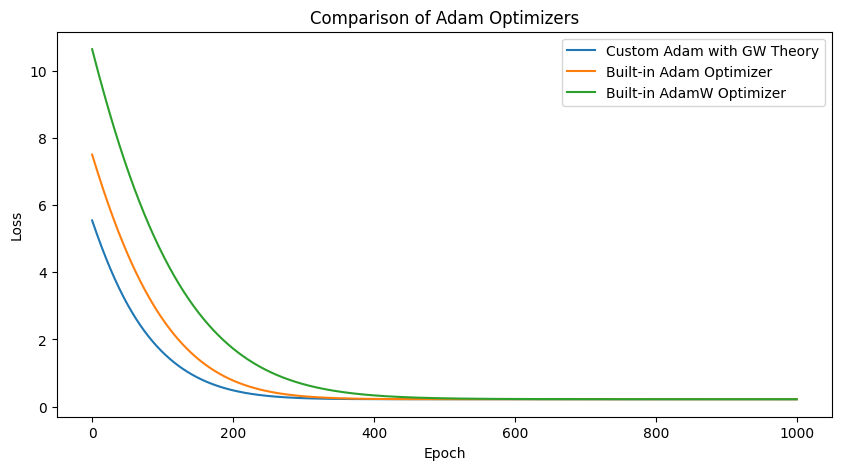

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data
x = np.random.randn(100)
y = 2 * x + 3 + np.random.randn(100) * 0.5  # true slope is 2, intercept is 3
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


class AdamOptimizerWithGWTheory(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps, base_lr=lr)
        super(AdamOptimizerWithGWTheory, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['last_persistence'] = 1

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                step_size = group['base_lr'] * (np.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step']))

                # Calculate persistence and adjust learning rate dynamically
                norm = p.data.norm().item()
                persistence = np.exp(-0.1 * norm)
                if persistence < state['last_persistence']:
                    step_size *= 1.1
                else:
                    step_size *= 0.9
                state['last_persistence'] = persistence

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


# Training setup
model = LinearRegressionModel()
criterion = nn.MSELoss()

# Using the custom optimizer
optimizer_custom = AdamOptimizerWithGWTheory(model.parameters(), lr=0.01)
# Using the built-in Adam optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
# Using the built-in AdamW optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Training loop
def train_model(optimizer, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

# Train with custom optimizer
print("Training with custom Adam optimizer with GW theory:")
losses_custom = train_model(optimizer_custom)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)

# Train with built-in Adam optimizer
print("Training with built-in Adam optimizer:")
losses_adam = train_model(optimizer_adam)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with built-in AdamW optimizer
print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(optimizer_adamw)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with GW Theory')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.title("Comparison of Adam Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Training with custom Adam optimizer with GW theory:
Epoch [1/5], Loss: 0.3145
Epoch [2/5], Loss: 0.1428
Epoch [3/5], Loss: 0.1052
Epoch [4/5], Loss: 0.0861
Epoch [5/5], Loss: 0.0725
Training with built-in Adam optimizer:
Epoch [1/5], Loss: 0.3088
Epoch [2/5], Loss: 0.1415
Epoch [3/5], Loss: 0.1045
Epoch [4/5], Loss: 0.0844
Epoch [5/5], Loss: 0.0745
Training with built-in AdamW optimizer:
Epoch [1/5], Loss: 0.3184
Epoch [2/5], Loss: 0.1438
Epoch [3/5], Loss: 0.1053
Epoch [4/5], Loss: 0.0859
Epoch [5/5], Loss: 0.0743
Custom Adam with GW Theory Accuracy: 97.42%
Built-in Adam Accuracy: 97.31%
Built-in AdamW Accuracy: 97.05%


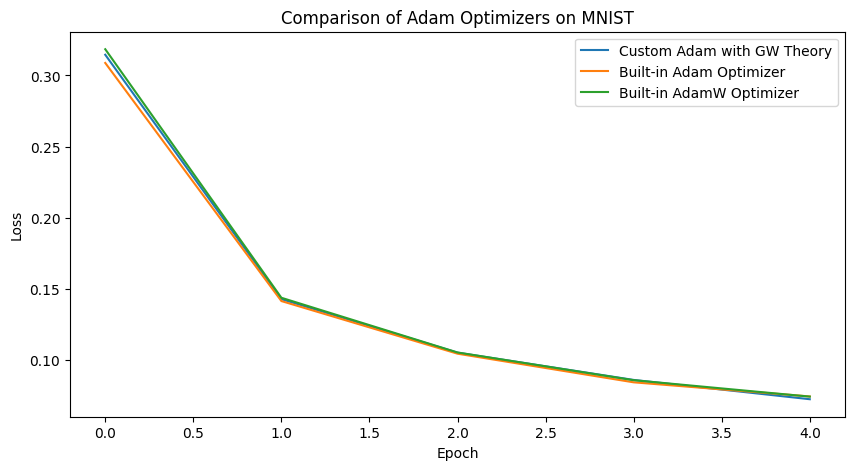

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, optimizer, criterion, trainloader, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses

# Testing function
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Initialize model, criterion, and optimizers
model_custom = Net()
model_adam = Net()
model_adamw = Net()

criterion = nn.CrossEntropyLoss()

optimizer_custom = AdamOptimizerWithGWTheory(model_custom.parameters(), lr=0.001)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.001)

# Train and test models
print("Training with custom Adam optimizer with GW theory:")
losses_custom = train_model(model_custom, optimizer_custom, criterion, trainloader)

print("Training with built-in Adam optimizer:")
losses_adam = train_model(model_adam, optimizer_adam, criterion, trainloader)

print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(model_adamw, optimizer_adamw, criterion, trainloader)

# Test accuracy
accuracy_custom = test_model(model_custom, testloader)
accuracy_adam = test_model(model_adam, testloader)
accuracy_adamw = test_model(model_adamw, testloader)

print(f"Custom Adam with GW Theory Accuracy: {accuracy_custom:.2f}%")
print(f"Built-in Adam Accuracy: {accuracy_adam:.2f}%")
print(f"Built-in AdamW Accuracy: {accuracy_adamw:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with GW Theory')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.title("Comparison of Adam Optimizers on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7c161974-9d6a-4482-9d07-5417184f71f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>